In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy
from scipy.optimize import curve_fit

In [8]:
# check header
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                66125 / length of dimension 1                          
NAXIS2  =                   93 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   72 / number of table fields                         
TTYPE1  = 'OBJECT  '                                                            
TFORM1  = '16A     '                                                            
TTYPE2  = 'BANDWID '                                                            
TFORM2  = '1D      '                                                            
TUNIT2  = 'Hz      '        

In [4]:
# open file
hdu = fits.open("/mnt/castor/home1/amigos/kohno/NANTEN2/std_ps/moon_data/n20180927084536_12CO_2-1_crossedge_moon_pointing.fits")

In [5]:
# check SOBSMODE
mode = hdu[1].data["SOBSMODE"]
print(mode)

['HOT' 'OFF' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON'
 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'HOT' 'OFF' 'ON' 'ON' 'ON'
 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON'
 'ON' 'ON' 'ON' 'ON' 'HOT' 'OFF' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON'
 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'HOT'
 'OFF' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON'
 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'ON' 'HOT']


In [6]:
# define axis / mask
lam = hdu[1].data["LAMDEL"]
bet = hdu[1].data["BETDEL"]
subscan = hdu[1].data["SUBSCAN"]

onmask = mode == "ON"
hotmask = mode == "HOT"
offmask = mode == "OFF"
xmask = (subscan == 1) & onmask
ymask = (subscan == 2) & onmask
subscan

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2], dtype=int32)

In [7]:
# calc Ta*
integlist = numpy.sum(hdu[1].data["DATA"][:, 3000:15000], axis = 1) ### range

tmp = []
HOT = integlist[hotmask]
for i in range(numpy.sum(hotmask) -1):
    tmp.extend([HOT[i] for j in range(int(len(hotmask)/4))])
tmp.append(HOT[numpy.sum(hotmask) -1])
HOTlist = numpy.array(tmp)

tmp = []
OFF = integlist[offmask]
for i in range(numpy.sum(offmask)):
    tmp.extend([OFF[i] for j in range(int(len(offmask)/4))])
tmp.append(OFF[numpy.sum(offmask) -1])
OFFlist = numpy.array(tmp)   

ONlist = integlist
        

Taslist = (ONlist - OFFlist)/(HOTlist - OFFlist) * 300

In [8]:
# create data for plot
xscan_Ta = Taslist[xmask]
xscan_x= lam[xmask]
xscan_y= bet[xmask]

yscan_Ta = Taslist[ymask]
yscan_x= lam[ymask]
yscan_y= bet[ymask]

In [9]:
# Differential function

xscan_tmp = numpy.roll(xscan_Ta,1)
xscan_tmp[0] = 0
yscan_tmp = numpy.roll(yscan_Ta, 1)
yscan_tmp[0] = 0

xscan_dif = xscan_Ta - xscan_tmp
yscan_dif = yscan_Ta - yscan_tmp

In [ ]:
# Gaussian Fitting function add errorbar
def gaussian(x, a, mu, gamma):
    return a * numpy.exp(- gamma * (x - mu) **2) 

x_az = numpy.linspace(xscan_x[0], xscan_x[-1], 2000)
para_init1 = numpy.array([75, -1000, 0.0001])###
para_init2 = numpy.array([-75, 1000, 0.0001])###

# dAz fitting
popt_az1, pcov_az1 = curve_fit(gaussian, xscan_x[:21], xscan_dif[:21], p0 = para_init1)
error_az1 = numpy.sqrt(numpy.diag(pcov_az1))
#print("error",error_az1)
popt_az2, pcov_az2 = curve_fit(gaussian, xscan_x[21:], xscan_dif[21:], p0 = para_init2)
error_az2 = numpy.sqrt(numpy.diag(pcov_az2))
#print("error",error_az2)


gaus_az1 = gaussian(x_az[:1000], popt_az1[0], popt_az1[1], popt_az1[2])
gaus_az2 = gaussian(x_az[1000:], popt_az2[0], popt_az2[1], popt_az2[2])

x_el = numpy.linspace(yscan_y[0], yscan_y[-1], 2000)

# El fitting
popt_el1, pcov_el1 = curve_fit(gaussian, yscan_y[:21], yscan_dif[:21], p0 = para_init1)
error_el1 = numpy.sqrt(numpy.diag(pcov_el1))
#print("error", error_el1)
popt_el2, pcov_el2 = curve_fit(gaussian, yscan_y[21:], yscan_dif[21:], p0 = para_init2)
error_el2 = numpy.sqrt(numpy.diag(pcov_el2))
#print("error", error_el2)

gaus_el1 = gaussian(x_el[:1000], popt_el1[0], popt_el1[1], popt_el1[2])
gaus_el2 = gaussian(x_el[1000:], popt_el2[0], popt_el2[1], popt_el2[2])

In [1]:
dAz_mi = popt_az1[1]
dAz_pu = popt_az2[1]
dEl_mi = popt_el1[1]
dEl_pu = popt_el2[1]

dAz = (dAz_mi + dAz_pu)/2
dEl = (dEl_mi + dEl_pu)/2

print("dAz_mi =", dAz_mi, "    dAz_pu =", dAz_pu, "    dAz =", dAz, "(arcsec)")
print("dEl_mi =", dEl_mi, "    dEl_pu =", dEl_pu, "    dEl =", dEl, "(arcsec)")

NameError: name 'popt_az1' is not defined

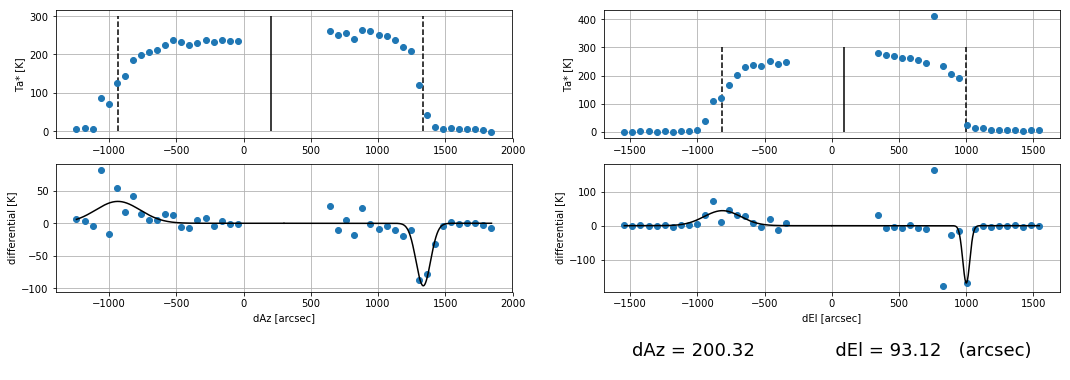

In [977]:
# Dif plot
fig = plt.figure(figsize = (18, 8))

axlist = [fig.add_subplot(3,2,i+1) for i in range(6)]

axlist[0].plot(xscan_x, xscan_Ta, "o")
axlist[0].vlines(dAz_mi, 0, 300, linestyle = "dashed")
axlist[0].vlines(dAz_pu, 0, 300, linestyle = "dashed")
axlist[0].vlines(dAz, 0, 300)
axlist[0].set_ylabel("Ta* [K]")

axlist[1].plot(yscan_y, yscan_Ta, "o")
axlist[1].vlines(dEl_mi, 0, 300, linestyle = "dashed")
axlist[1].vlines(dEl_pu, 0, 300, linestyle = "dashed")
axlist[1].vlines(dEl, 0, 300)
axlist[1].set_ylabel("Ta* [K]")

axlist[2].plot(xscan_x, xscan_dif, "o")
axlist[2].plot(x_az[:1000], gaus_az1, color="k")
axlist[2].plot(x_az[1000:], gaus_az2, color="k")
axlist[2].set_xlabel("dAz [arcsec]")
axlist[2].set_ylabel("differential [K]")

axlist[3].plot(yscan_y, yscan_dif, "o")
axlist[3].plot(x_el[:1000], gaus_el1, color="k")
axlist[3].plot(x_el[1000:], gaus_el2, color="k")
axlist[3].set_xlabel("dEl [arcsec]")
axlist[3].set_ylabel("differential [K]")

axlist[4].set_visible(False)
axlist[5].set_visible(False)

plt.axes([0.57,0.28, 0.25, 0.2])
plt.axis("off")
plt.text(0,0,"dAz = {}".format(round(dAz, 2)) + "              dEl = {}".format(round(dEl, 2)) + "   (arcsec)", fontsize = 18)

    
[a.grid() for a in axlist]
plt.show()

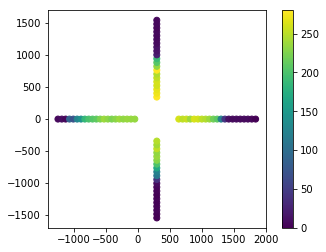

In [978]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, aspect = 1)

im = ax.scatter(xscan_x, xscan_y, c = xscan_Ta, vmin = 0, vmax = 280)
ax.scatter(yscan_x, yscan_y, c = yscan_Ta, vmin = 0, vmax = 280)

fig.colorbar(im)

plt.show()

In [1]:
fig = plt.figure(figsize = (18, 8))

axlist = [fig.add_subplot(3,2,i+1) for i in range(6)]

axlist[0].plot(xscan_x, xscan_Ta, "o")
axlist[0].set_ylabel("Ta* [K]")

axlist[1].plot(yscan_y, yscan_Ta, "o")
axlist[1].set_ylabel("Ta* [K]")

axlist[2].plot(xscan_x, xscan_dif, "o")
axlist[2].set_xlabel("dAz [arcsec]")
axlist[2].set_ylabel("differential [K]")

axlist[3].plot(yscan_y, yscan_dif, "o")
axlist[3].set_xlabel("dEl [arcsec]")
axlist[3].set_ylabel("differential [K]")

axlist[4].set_visible(False)
axlist[5].set_visible(False)

plt.axes([0.57,0.28, 0.25, 0.2])
plt.axis("off")

    
[a.grid() for a in axlist]
plt.show()

NameError: name 'plt' is not defined